In [2]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

from fastai.vision import *
from fastai.callbacks.hooks import *
from fastai.utils.mem import *
import os

os.environ["TORCH_HOME"] = "/media/subhaditya/DATA/COSMO/Datasets-Useful"

In [3]:
path = untar_data(URLs.CIFAR)

In [4]:
data = (
    (
        ImageList.from_folder(path)
        .split_by_rand_pct()
        .label_from_folder()
        .transform(get_transforms(), size=32)
    )
    .databunch(bs=64)
    .normalize(imagenet_stats)
)

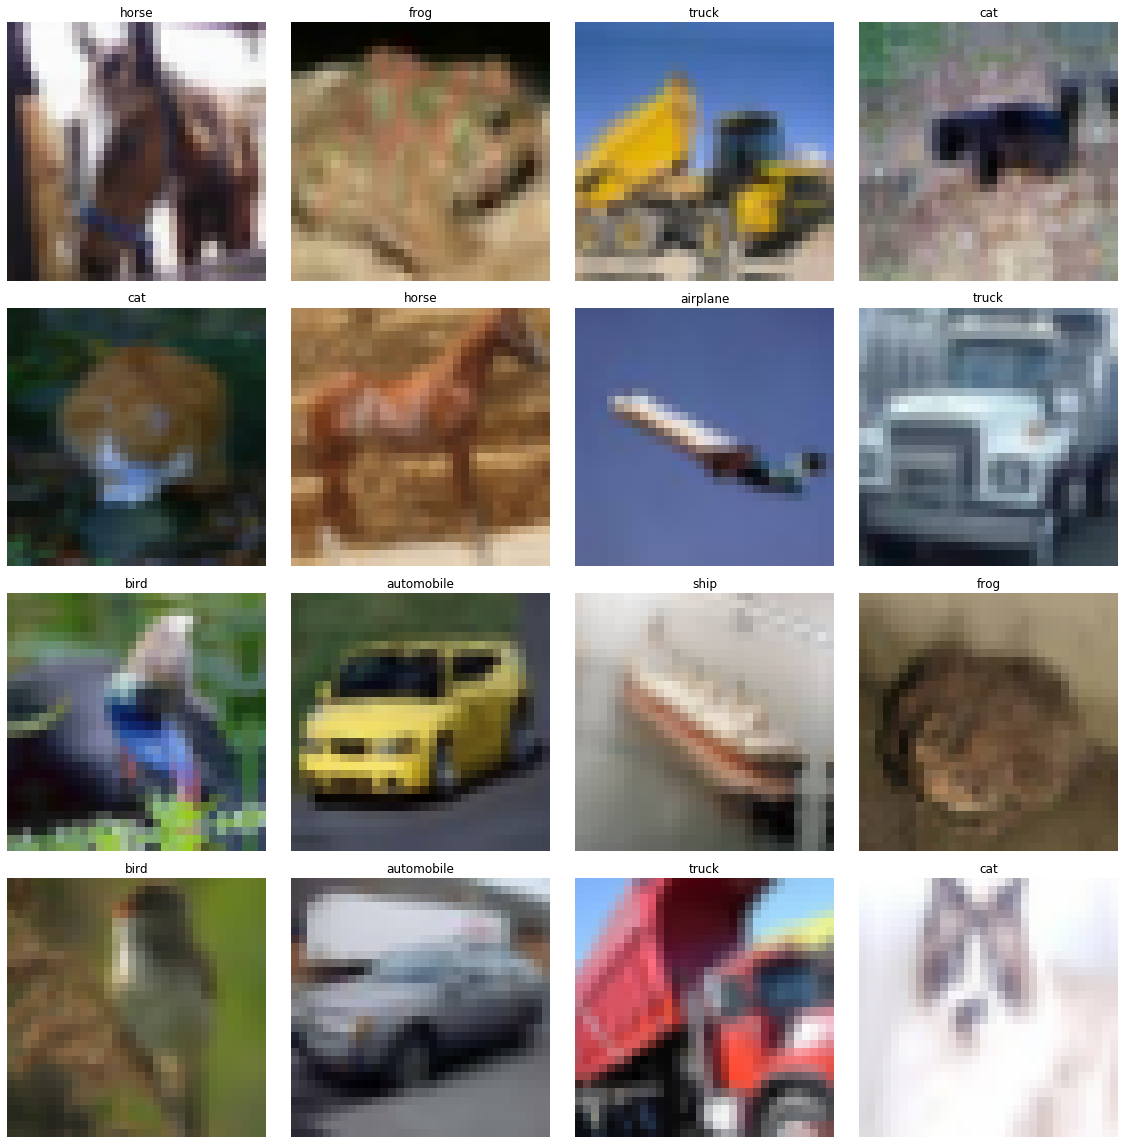

In [5]:
data.show_batch(4)

In [6]:
data.c

10

In [7]:
learn = None
gc.collect()

35393

In [8]:

def conv3x3(in_planes, out_planes, stride=1):
    ### 3x3 convolution with padding
    return nn.Conv2d(in_planes, out_planes, kernel_size=3, stride=stride,
                     padding=1, bias=False)

def bilinear(scale_factor=2):
    ### bilinear upsampling
    return nn.Upsample(scale_factor=scale_factor, mode='bilinear')


In [9]:


class Shrink(nn.Module):
    ### downsample skip connection resolution and adjust its feature dimension for channel doubling fabric and 1x1 gating
    def __init__(self, inc, outc, gating):
        super(Shrink, self).__init__()
        self.max_pool = nn.MaxPool2d(2, stride=2)
        self.conv = None
        self.bn = None
        if inc != outc or gating=='1x1':   ### channel doubling fabric and 1x1 gating
            self.conv = nn.Conv2d(inc, outc, kernel_size=1, stride=1, bias=False)
            self.bn = nn.BatchNorm2d(outc)

    def forward(self, x):
        x = self.max_pool(x)
        if self.conv is not None:
            x = self.bn(self.conv(x))

        return x



In [10]:


class Expand(nn.Module):
    ### adjust skip connection feature dimension for channel doubling fabric and 1x1 gating
    def __init__(self, inc, outc, gating):
        super(Expand, self).__init__()
        self.conv = None
        self.bn = None
        if inc != outc or gating=='1x1':   ### channel doubling fabric and 1x1 gating
            self.conv = nn.Conv2d(inc, outc, kernel_size=1, stride=1, bias=False)
            self.bn = nn.BatchNorm2d(outc)

    def forward(self, x):
        if self.conv is not None:
            x = self.bn(self.conv(x))
        return x


In [11]:


    
class ClassicFabricNode(nn.Module):
    def __init__(self, planes, block = 'conv', activations = 'post'):
        super(ClassicFabricNode, self).__init__()
        
        self.bn = None
        self.relu = None

        if block == 'conv' or (activations=='post' and block == 'bottleneck'):   ### bn and relu are done inside bottlenck unit for pre activation
            self.bn = nn.BatchNorm2d(planes)
            self.relu = nn.ReLU(inplace=True)
    
    def forward(self, x):

        out = torch.sum(x, dim = 0)          ### add all incoming activation maps

        if self.bn is not None:
            out = self.bn(out)
        if self.relu is not None:
            out = self.relu(out)

        return out


In [12]:




class BottleneckPre(nn.Module):
    expansion = 4

    def __init__(self, inplanes, planes, stride=1, downsample=None, 
        gating = None, op_count = 1):
        super(BottleneckPre, self).__init__()
        
        self.relu = nn.ReLU(inplace=True)
        self.bn1 = nn.BatchNorm2d(inplanes)
        self.conv1 = nn.Conv2d(inplanes, planes, kernel_size=1, bias=False)

        self.bn2 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3, stride=stride, 
            padding=1, bias=False)
        
        self.bn3 = nn.BatchNorm2d(planes)
        self.conv3 = nn.Conv2d(planes, planes * 4, kernel_size=1, bias=False)
        

        self.downsample = None
        
        if downsample == 'shrink':
            self.downsample = Shrink(inplanes, planes*4, gating)
        if downsample == 'expand':
            self.downsample = Expand(inplanes, planes*4, gating)

        if gating == '1x1':
            gating = None

        self.op_count = op_count   #### number of outgoing connections
        self.gating = gating
        self.val = 1
        if self.gating == 'scaling':
            self.val = 1.0/self.op_count
            print ('scaling by' , self.val)



    def forward(self, x):

        out = self.bn1(x)
        out = self.relu(out)
        out = self.conv1(x)
           
        out = self.bn2(out)
        out = self.relu(out)
        out = self.conv2(out)

        out = self.bn3(out)
        out = self.relu(out)
        out = self.conv3(out)

        residual = x

        if self.downsample is not None:
            residual = self.downsample(residual)

        if self.gating == 'total_dropout':
            if np.random.randint(self.op_count) > 0:   ### probability of remaining active is 1/op_count
                self.val = 0

        if self.gating is not None:
            residual = torch.mul(residual, self.val)

                    
        out += residual
            

        return out




In [13]:



class Bottleneck(nn.Module):
    expansion = 4

    def __init__(self, inplanes, planes, stride=1, downsample=None,
     gating = None, op_count = 1):
        super(Bottleneck, self).__init__()
        
        self.relu = nn.ReLU(inplace=True)
        self.conv1 = nn.Conv2d(inplanes, planes, kernel_size=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3, stride=stride, 
            padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)
        
        self.conv3 = nn.Conv2d(planes, planes * 4, kernel_size=1, bias=False)
        self.bn3 = nn.BatchNorm2d(planes * 4)
        self.downsample = None
        
        
        if downsample == 'shrink':
            self.downsample = Shrink(inplanes, planes*4, gating)
        if downsample == 'expand':
            self.downsample = Expand(inplanes, planes*4, gating)

        if gating == '1x1':
            gating = None

        self.op_count = op_count
        self.gating = gating
        self.val = 1
        if self.gating == 'scaling':
            self.val = 1.0/self.op_count
            print ('scaling by' , self.val)


    def forward(self, x):
               
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)
        out = self.relu(out)

        out = self.conv3(out)
        out = self.bn3(out)        

        residual = x

        if self.downsample is not None:
            residual = self.downsample(residual)

        if self.gating == 'total_dropout':
            if np.random.randint(self.op_count) > 0:   ### probability of remaining active is 1/op_count
                self.val = 0

        if self.gating is not None:
            residual = torch.mul(residual, self.val)



        out += residual
        out = self.relu(out)
            

        return out


In [14]:


class ConvolutionalNeuralFabrics(nn.Module):
    def __init__(self, layers, scales, channels, num_classes, classifier_scale, 
        fabric_unit = 'a', block = 'conv', activations='post', gating = None): 

        super(ConvolutionalNeuralFabrics, self).__init__()
        self.layers = layers
        self.scales = scales
        self.channels = channels
        self.classifier_scale = classifier_scale
        self.fabric_unit = fabric_unit   ### type 'a' or 'd'
        self.activations = activations   ### 'pre' or 'post'
        self.gating = gating             ### None, total_dropout, scaling or '1x1'
        self.num_operations = 6    ### forward, zipper_down, zipper_up, up, down, node operations

        self.d0_conv = nn.Conv2d(3, self.channels[0], kernel_size=3, stride=1, padding=1, bias=False)
        
        self.bn_c = None
        self.relu_c = None

        if self.activations == 'pre':    ### apply preactivation activation for classifier
            self.bn_c = nn.BatchNorm2d(self.channels[self.classifier_scale])
            self.relu_c = nn.ReLU(inplace=True)
            

        self.classifier = nn.Conv2d(self.channels[self.classifier_scale], num_classes, kernel_size=1, bias=True)

        self.upsample = bilinear()
        
        fabrics = []

        for l in range(self.layers):
            scale_ = []
            for s in range(self.scales):

                forward = None
                zipper_down = None
                zipper_up = None
                up = None
                down = None               
                
                
                op_count = 0
                
                #### number of outgoing connections needed for gating
                if self.gating == 'scaling' or self.gating == 'total_dropout':
                    if l < (self.layers-1):
                        op_count += 1
                        if s>0:
                            op_count += 1
                        if s<(self.scales-1):
                            op_count += 1
                    if fabric_unit == 'a':
                        if (l==0 or l==(self.layers-1)) and s<(self.scales-1) :
                            op_count += 1
                    elif fabric_unit == 'd':
                        if l%2==0 and s<(self.scales-1) :
                            op_count += 1
                        if l%2==1 and s>0 :
                            op_count += 1
                
                    print ('op_count',l, s, op_count)

                node = ClassicFabricNode(planes = self.channels[s], block = block, activations = self.activations)

                if l<(self.layers-1):
                    ### forward
                    fin_out = [self.channels[s], self.channels[s]]
                    if block=='conv':
                        forward = conv3x3(fin_out[0], fin_out[1])
                    elif block == 'bottleneck':
                        if self.activations == 'post':
                            forward = Bottleneck(fin_out[0], fin_out[1]/4, gating = self.gating, op_count = op_count)
                        elif self.activations == 'pre':
                            forward = BottleneckPre(fin_out[0], fin_out[1]/4, gating = self.gating, op_count = op_count)
                    

                    ### up
                    if s>0:
                        uin_out = [self.channels[s], self.channels[s-1]]
                        if block=='conv':
                            up = conv3x3(uin_out[0], uin_out[1])
                        elif block == 'bottleneck':
                            if self.activations == 'post':
                                up = Bottleneck(uin_out[0], uin_out[1]/4, downsample = 'expand', gating = self.gating, op_count = op_count)
                            elif self.activations == 'pre':
                                up = BottleneckPre(uin_out[0], uin_out[1]/4, downsample = 'expand', gating = self.gating, op_count = op_count)

                    ### down
                    if s<(self.scales-1):
                        din_out = [self.channels[s], self.channels[s+1]] 
                        if block=='conv':
                            down = conv3x3(din_out[0], din_out[1], stride = 2)
                        elif block == 'bottleneck':
                            if self.activations == 'post':
                                down = Bottleneck(din_out[0],din_out[1]/4, stride = 2, downsample='shrink', gating = self.gating, op_count = op_count)
                            elif self.activations == 'pre':
                                down = BottleneckPre(din_out[0],din_out[1]/4, stride = 2, downsample='shrink', gating = self.gating, op_count = op_count)
                        
                ### zipper in type a for first and last layers
                if fabric_unit == 'a':
                    if (l==0 or l==(self.layers-1)) and s<(self.scales-1) :
                        zdin_out = [self.channels[s], self.channels[s+1]]
                        if block=='conv':
                            zipper_down = conv3x3(zdin_out[0], zdin_out[1], stride = 2)
                        elif block == 'bottleneck':
                            if self.activations == 'post':
                                zipper_down = Bottleneck(zdin_out[0], zdin_out[1]/4, stride = 2, downsample='shrink', gating = self.gating, op_count = op_count)
                            elif self.activations == 'pre':
                                zipper_down = BottleneckPre(zdin_out[0], zdin_out[1]/4, stride = 2, downsample='shrink', gating = self.gating, op_count = op_count)
                        
                ### zipper in type d for even (zipper_down) and odd layers (zipper_up)
                elif fabric_unit == 'd':
                    if l%2==0 and s<(self.scales-1) :
                        zdin_out = [self.channels[s], self.channels[s+1]]
                        if block=='conv':
                            zipper_down = conv3x3(zdin_out[0], zdin_out[1], stride = 2)
                        elif block == 'bottleneck':
                            if self.activations == 'post': 
                                zipper_down = Bottleneck(zdin_out[0], zdin_out[1]/4, stride = 2, downsample='shrink', gating = self.gating, op_count = op_count)
                            elif self.activations == 'pre':
                                zipper_down = BottleneckPre(zdin_out[0], zdin_out[1]/4, stride = 2, downsample='shrink', gating = self.gating, op_count = op_count)
                    ### zipper_up
                    if l%2==1 and s>0 :
                        zuin_out = [self.channels[s], self.channels[s-1]]
                        if block=='conv':
                            zipper_up = conv3x3(zuin_out[0], zuin_out[1])
                        elif block == 'bottleneck':
                            if self.activations == 'post':
                                zipper_up = Bottleneck(zuin_out[0], zuin_out[1]/4, downsample='expand', gating = self.gating, op_count = op_count)
                            elif self.activations == 'pre':
                                zipper_up = BottleneckPre(zuin_out[0], zuin_out[1]/4, downsample='expand', gating = self.gating, op_count = op_count)



                scale_ += [forward, zipper_down, zipper_up, up, down, node]

            fabrics += scale_

        self.fabrics = nn.ModuleList(fabrics)


        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                n = m.kernel_size[0] * m.kernel_size[1] * m.out_channels
                m.weight.data.normal_(0, math.sqrt(2. / n))
            elif isinstance(m, nn.BatchNorm2d):
                m.weight.data.fill_(1)
                m.bias.data.zero_()

    def forward(self, x):
        intermediate_outputs = {}

        out = self.d0_conv(x)

        intermediate_outputs['d0_0'] = [out]
        ### fabric computation graph
        for l in range(self.layers):
            for s in range(self.scales):
                
                ### get inputs to current node
                inputs = intermediate_outputs['d'+str(l)+'_'+str(s)]

                ### delete intermediate outputs
                intermediate_outputs['d'+str(l)+'_'+str(s)] = []

                temp = ()
                for inp in inputs:
                    size_ = inp.size()
                    inp = inp.view(1, size_[0], size_[1], size_[2], size_[3])
                    temp = temp + (inp,)

                temp_ = torch.cat(temp, dim = 0)

                ### identify set of operations/layers to apply
                layer_index = l*self.scales*self.num_operations + s*self.num_operations

                out = self.fabrics[layer_index+5](temp_)    ### sum all incoming activation map

                ### fabric outputs are saved in outputs list
                if l==(self.layers-1) and s == self.classifier_scale:
                    outputs=out

                ### branch out from current node
                if self.fabrics[layer_index+0] is not None:
                    forward = self.fabrics[layer_index+0](out)
                    intermediate_outputs['d'+str(l+1)+'_'+str(s)] = intermediate_outputs.get('d'+str(l+1)+'_'+str(s), []) + [forward]

                if self.fabrics[layer_index+1] is not None:
                    zipper_down = self.fabrics[layer_index+1](out)
                    intermediate_outputs['d'+str(l)+'_'+str(s+1)] = intermediate_outputs.get('d'+str(l)+'_'+str(s+1), []) + [zipper_down]

                if self.fabrics[layer_index+2] is not None:
                    zipper_up = self.fabrics[layer_index+2](self.upsample(out))
                    intermediate_outputs['d'+str(l)+'_'+str(s-1)] = intermediate_outputs.get('d'+str(l)+'_'+str(s-1), []) + [zipper_up]

                if self.fabrics[layer_index+3] is not None:
                    up = self.fabrics[layer_index+3](self.upsample(out))
                    intermediate_outputs['d'+str(l+1)+'_'+str(s-1)] = intermediate_outputs.get('d'+str(l+1)+'_'+str(s-1), []) + [up]

                if self.fabrics[layer_index+4] is not None:
                    down = self.fabrics[layer_index+4](out)
                    intermediate_outputs['d'+str(l+1)+'_'+str(s+1)] = intermediate_outputs.get('d'+str(l+1)+'_'+str(s+1), []) + [down]


        
        if self.bn_c is not None:
            outputs = self.bn_c(outputs)

        if self.relu_c is not None:
            outputs = self.relu_c(outputs)

        return self.classifier(outputs)

In [16]:
learn = Learner(
    data, ConvolutionalNeuralFabrics(layers=8, num_classes=10, scales=6, classifier_scale=5, channels=[128, 128, 128, 128, 128, 128], fabric_unit='a',block='conv'), metrics=[accuracy], opt_func=AdamW, callback_fns=ShowGraph, loss_func=nn.CrossEntropyLoss
).to_fp16()


In [17]:
learn.unfreeze()
learn.lr_find()
learn.recorder.plot()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


ValueError: Expected input batch_size (640) to match target batch_size (64).

In [ ]:
learn.unfreeze()
learn.fit_one_cycle(5, 1e-4)

In [ ]:
learn.show_results()